# Practical to Evaluate Using CCA As a Bias Correction Technique for Seasonal Forecasts
In this practical, we will use some forecast models to generate some seasonal precipitation and sea surface temperature (SST) forecasts, and then assess how the raw precipitation forecasts compare two applications of CCA as a bias correction techniques **(1)** statistically correcting precipitation forecasts and **(2)** using teleconnection patterns with sea surface temperature (SST) to statistically correct raw SST forecasts and generate a bias-corrected precipitation forecast.

The bias correction technique assessed is Canonical Correlation Analysis (CCA), which bias corrects forecasts by seeking correlation patterns across large spatial domains using Empirical Orthogonal Functions.

The usefulness of this technique is especially sensitive to the extent of the spatial domain of the model used for training(predictor extent). We will test how varying the spatial extent of the predictors affects the performance of CCA as a bias correction technique.

**This notebook should be run in the intdesk_train environment - check your kernel (upper righthand corner) is set to 'intdesk_train', so you have all necessary libraries**


## Libraries

In [1]:
import xcast as xc
import datetime as dt
from datetime import datetime
import numpy as np
from pathlib import Path
import xarray as xr
import os
import time
import cartopy.crs as ccrs
import cartopy.feature as cf
import matplotlib.pyplot as plt
import glob
from cartopy.feature import NaturalEarthFeature

## Project Directory Setup
setup the folder where you want to work for this project

either set project_dir equal to the location of your working directory, e.g. "/Users/katie/Desktop/pacisl_training" or place this notebook in the folder where you want your project to live and set project_dir = os.getcwd()

In [2]:
project_dir = os.getcwd()
print('Project Directory is Located in ' + project_dir)

#makes subdirectores to organize your work within the project if they don't already exist
os.makedirs(os.path.join(project_dir, 'practical_data'), exist_ok = True)
data_dir = os.path.join(project_dir, 'practical_data')
os.makedirs(os.path.join(project_dir, 'practical_figures'), exist_ok = True)
figure_dir = os.path.join(project_dir, 'practical_figures')

Project Directory is Located in /cpc/int_desk/pac_isl/analysis/xcast/seasonal/practical_notebooks


### Add all of your data for this practical into your 'practical_data' folder now

## Setup Your Constants: Spatial Extents and Dates

**(1) initialization date**: Make sure this date is not set for a future month but in a present or past month, and then seasonal forecasts will be created for 3 target periods following that month. For instance if you pick (2023,8,1) as your initialization date, you will evaluate forecasts over Sep-Nov, Oct-Dec, and Dec-Feb.

In [3]:
## PICK YOUR DATE you want to initialize the model, e.g. your current date
initial_date = (2023, 8, 1)

**(2) region of interest**: Several coordinates have been setup in this cell. Make sure your region_coords variable is equal to the name of one of the coordinate dictionary entries in this cell, and then name that region as you like, e.g. region_coords = solomon_coordinates, region_of_interest = 'Solomon Islands'.
You can adjust the coordinate values as you like in the dictionaries if you want to play around with the predictand extent, just remember to keep the naming consistent.

In [4]:
#some predefined zones, update the numbers if you wish, or add another zone following the same labelling structure
pacislands_coordinates = {
    'west': 130,
    'east': 205,
    'north': 8,
    'south': -20
    }

chuuk_coordinates = {
    'west': 151,
    'east': 153,
    'north': 8,
    'south': 6
    }

fiji_coordinates = {
    'west':  177,
    'east': 182,  
    'north': -15,  
    'south': -20}

kiribati_coordinates = {
        'west':  202,
        'east': 203,  
        'north': 3,  
        'south': 1}

solomon_coordinates = {
        'west':  155,
        'east': 167,  
        'north': -6,  
        'south': -13}

png_coordinates = {
        'west':  130,
        'east': 156,  
        'north': 1,  
        'south': -12}
        
palau_coordinates = {
        'west':  133,
        'east': 135,  
        'north': 8,  
        'south': 6
}
        
vanuatu_coordinates = {
        'west':  165,
        'east': 170,  
        'north': -12,  
        'south': -20
}

samoa_coordinates = {
        'west':  187,
        'east': 191,  
        'north': -13,  
        'south': -15
}

tuvalu_coordinates = {
        'west':  178,
        'east': 180,  
        'north': -8,  
        'south': -9
}

In [5]:
### PICK YOUR TARGET REGION OF INTEREST
region_of_interest = 'Papua New Guinea' #how you want to name your region (can include spaces)
region_coords = png_coordinates #name of the coordinates to use for your region, as defined above

**(3) type of predictor**: This will either be set to 'sst' or 'precip', which will affect the type of forecast you generate, either using raw NMME SST predictions and statistically relating those to rainfall observations over a training period or raw NMME rainfall predictions and statistically relating those to rainfall observations over a training period.

In [6]:
### PICK YOUR PREDICTOR, either choose 'precip' or 'sst'
predictor_type = 'sst'

**(4) predictor extent**: This is the spatial domain of your model to train your data, and it will affect how the bias correction performs by creating a zone of interest upon which the model can train. A few zones of interest have been setup for you here, including 'tropicaloceans', 'pacific', and 'ENSO'. You will likely only need to play around with 'tropicaloceans' if you are generating an SST-based forecast. You can fine tune these parameters by adding additional coordinate dictionaries here or updating the ones created originally. Make sure to name the predictor extent at the end that aligns with your coordinate dictionary to you remember what you trained on when you save your files (the name is how the files will get saved).

In [7]:
### PICK YOUR PREDICTOR TRAINING ZONE

#some options outlined below
#Pacific region, encompassing all islands
pacific_extent = {
    'west': 120,
    'east': 210,
    'north': 10,
    'south': -30
}

#ENSO Nino34 region
ENSO_extent = {
    'west': 120,
    'east': 180,
    'north': 5,
    'south': -5
}

#Global tropical oceans, including Pacific and Atlantic
tropicaloceans_extent = {
    'west': 120,
    'east': 270,
    'north': 20,
    'south': -20
}

predictor_train_extent = pacific_extent
predictor_train_extent_name = 'pacific'

## Prepare Data for Analysis

In [8]:
#this cell is setup to calculate your target forecast months based on your initialization date
#the forecast months are currently seto to be 1-3, 2-4 and 3-5 months ahead
number_to_month_name_dictionary = {
    1: 'Jan',
    2: 'Feb',
    3: 'Mar',
    4: 'Apr',
    5: 'May',
    6: 'Jun',
    7: 'Jul',
    8: 'Aug',
    9: 'Sep',
    10: 'Oct',
    11: 'Nov',
    12: 'Dec',
    0: 'Dec'
}

leads = [['1', '3'],['2', '4'], ['3','5']]
initial_month = dt.datetime(*initial_date).month
initial_month_name = number_to_month_name_dictionary[initial_month]
target_seas = []
for l in leads:
    target_low = number_to_month_name_dictionary[(initial_month + float(l[0]))%12]
    target_high = number_to_month_name_dictionary[(initial_month + float(l[1]))%12]
    target_seas.append('-'.join([target_low, target_high]))
print('Target seasons to forecast')
print(target_seas)

Target seasons to forecast
['Sep-Nov', 'Oct-Dec', 'Nov-Jan']


### Load Observations and Model Data

In [9]:
obs_leads = xr.open_dataset(os.path.join(data_dir, '_'.join([initial_month_name, 'threeseas_CMORPH_precip.nc'])))

#train the model on observations over a grid slightly larger than the region of interest
#this could be updated for later fine-tuning, but calculated here to keep it simple for now
if region_coords == palau_coordinates:
    predictand_train_extent = {
        'west':  region_coords['west']-10,
            'east': region_coords['east']+10,  
            'north': region_coords['north']+3,  
            'south': region_coords['south']-10
    }
else:
    predictand_train_extent = {
        'west':  region_coords['west']-5,
            'east': region_coords['east']+5,  
            'north': region_coords['north']+3,  
            'south': region_coords['south']-2
    }
obs_leads = obs_leads.sel(X=slice(predictand_train_extent['west'], predictand_train_extent['east']),
                          Y=slice(predictand_train_extent['south'], predictand_train_extent['north']))
print(obs_leads)

# read in hindcast and forecast data
hindcast_data = xr.open_dataset(os.path.join(data_dir, '_'.join([initial_month_name, 'threeseas_NMME_hcst', predictor_type + '.nc'])))
forecast_data = xr.open_dataset(os.path.join(data_dir, '_'.join([initial_month_name, 'threeseas_NMME_fcst', predictor_type + '.nc'])))

hindcast_data = hindcast_data.sel(X=slice(predictor_train_extent['west'], predictor_train_extent['east']),
                          Y=slice(predictor_train_extent['south'], predictor_train_extent['north']))
forecast_data = forecast_data.sel(X=slice(predictor_train_extent['west'], predictor_train_extent['east']),
                          Y=slice(predictor_train_extent['south'], predictor_train_extent['north']))

#read in the ocean mask for the region (makes it easier to see the plots)
msk = xr.open_dataset(os.path.join(data_dir, 'pacific_mask.nc'))
mskk = msk.amask.expand_dims({'M':[0]})
mskk = mskk.assign_coords({'lon': [i + 360 if i <= 0 else i for i in mskk.coords['lon'].values]}).sortby('lon').drop_duplicates('lon')
mskk = mskk.rename({'lon':'X', 'lat':'Y', 'time':'T'})
mskk = xc.regrid(mskk, obs_leads.X, obs_leads.Y)
mask_missing = mskk.mean('T', skipna=False).mean('M', skipna=False)
mask_missing = xr.ones_like(mask_missing).where(~np.isnan(mask_missing), other=np.nan )

if region_coords == chuuk_coordinates:
    obs_leads = obs_leads.copy()
else:
    obs_leads = obs_leads * mask_missing

<xarray.Dataset>
Dimensions:  (L: 3, M: 1, Y: 73, X: 125, T: 75)
Coordinates:
  * L        (L) int64 1 2 3
  * M        (M) int64 0
  * Y        (Y) float32 -14.0 -13.75 -13.5 -13.25 -13.0 ... 3.25 3.5 3.75 4.0
  * X        (X) float32 130.0 130.2 130.5 130.8 ... 160.2 160.5 160.8 161.0
  * T        (T) datetime64[ns] 2023-08-01 2024-08-01 ... 2096-08-01 2097-08-01
Data variables:
    precip   (L, M, T, Y, X) float64 ...


#### Check your region of interest is what you want

<xarray.DataArray 'precip' (M: 1, Y: 73, X: 125)>
array([[[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [7.8720665 , 7.69031763, 7.40345335, ...,        nan,
                nan,        nan]]])
Coordinates:
    L        int64 3
  * M        (M) int64 0
  * Y        (Y) float32 -14.0 -13.75 -13.5 -13.25 -13.0 ... 3.25 3.5 3.75 4.0
  * X        (X) float32 130.0 130.2 130.5 130.8 ... 160.2 160.5 160.8 161.0
    T        datetime64[ns] 2023-08-01


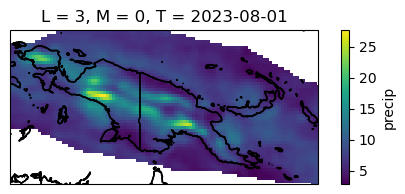

In [10]:
obs_check = obs_leads.sel(X=slice(predictand_train_extent['west'], predictand_train_extent['east']),
                          Y=slice(predictand_train_extent['south'], predictand_train_extent['north']))

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6,2), 
                         subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})
axes._autoscaleXon = False
axes._autoscaleYon = False
print(obs_check.isel(T=0, L=2).precip)
# Your plotting code here using the specific model and season
xplot = obs_check.isel(T=0, L=2).precip.plot(ax=axes,
                                 transform=ccrs.PlateCarree())
axes.coastlines()
c = axes.coastlines()
# Add country borders
axes.add_feature(NaturalEarthFeature(category='cultural', name='admin_0_countries', 
                                    scale='50m', edgecolor='black', facecolor='none'))
# Set the extent to cover the specific area
axes.set_extent([region_coords['west'], region_coords['east'], region_coords['south'], region_coords['north']], crs=ccrs.PlateCarree())

## Analysis

### Bias correct raw model outputs using Canonical Correlation Analysis (CCA)

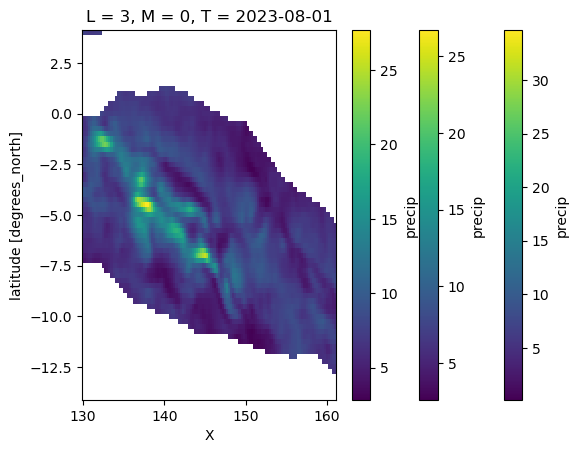

In [20]:
for l in np.unique(hindcast_data.L):
    obs = obs_leads.sel(L=l).precip
    model = hindcast_data.sel(L=l)[predictor_type]
    fmodel = forecast_data.sel(L=l)[predictor_type]
    obs.isel(T=0).plot()

In [25]:
start_time = time.time()
cca_fcsts_prob, cca_fcsts_det, cca_hcasts_det, cca_hcasts_prob, obs_to_test = [],[],[],[],[]
y_cca_loadings_test, x_cca_loadings_test, y_eof_loadings_test, x_eof_loadings_test = [],[],[],[]

for l in np.unique(hindcast_data.L):
    obs = obs_leads.sel(L=l).precip
    model = hindcast_data.sel(L=l)[predictor_type]
    fmodel = forecast_data.sel(L=l)[predictor_type]

    #run CCA
    hindcasts_det, hindcasts_prob, obs_test, y_cca_loadings, x_cca_loadings, y_eof_loadings, x_eof_loadings = [], [], [], [], [], [], []
    i=1
    for xtrain, ytrain, xtest, ytest in xc.CrossValidator(model, obs, window=5):
        print("window {}".format(i))
        i += 1
        reg = xc.CCA(search_override=(5,
                                      5,
                                     3))
        reg.fit(xtrain, ytrain)
        preds = reg.predict(xtest)
        probs =  reg.predict_proba(xtest)
        obs_test.append(ytest)

        hindcasts_det.append(preds)
        hindcasts_prob.append(probs)
        x_cca_loadings.append(reg.x_cca_loadings)
        y_cca_loadings.append(reg.y_cca_loadings)
        x_eof_loadings.append(reg.x_eof_loadings)
        y_eof_loadings.append(reg.y_eof_loadings)
    hindcasts_det = xr.concat(hindcasts_det, 'T')
    hindcasts_prob = xr.concat(hindcasts_prob, 'T')
    obs_test = xr.concat(obs_test, 'T')

    x_cca_loadings = xr.concat(x_cca_loadings, 'T')
    y_cca_loadings = xr.concat(y_cca_loadings, 'T')
    x_eof_loadings = xr.concat(x_eof_loadings, 'T')
    y_eof_loadings = xr.concat(y_eof_loadings, 'T')
    
    fprobs =  reg.predict_proba(fmodel)
    
    cca_fcsts_prob.append(fprobs)
    cca_hcasts_det.append(hindcasts_det)
    cca_hcasts_prob.append(hindcasts_prob)
    obs_to_test.append(obs_test)

    y_cca_loadings_test.append(y_cca_loadings)
    x_cca_loadings_test.append(x_cca_loadings)
    y_eof_loadings_test.append(y_eof_loadings)
    x_eof_loadings_test.append(x_eof_loadings)
cca_fcsts_prob = xr.concat(cca_fcsts_prob, dim = 'L')
cca_hcasts_det = xr.concat(cca_hcasts_det, dim = 'L')
cca_hcasts_prob = xr.concat(cca_hcasts_prob, dim = 'L')
obs_to_test = xr.concat(obs_to_test, dim = 'L')

y_cca_loadings_test = xr.concat(y_cca_loadings_test, dim = 'L')
x_cca_loadings_test = xr.concat(x_cca_loadings_test, dim = 'L')
y_eof_loadings_test = xr.concat(y_eof_loadings_test, dim = 'L')
x_eof_loadings_test = xr.concat(x_eof_loadings_test, dim = 'L')
print('cca processing time is ' + str(time.time() - start_time))

window 1
window 2
window 3
window 4
window 5
window 6
window 7
window 8
window 9
window 10
window 11
window 12
window 13
window 14
window 15
window 16
window 17
window 18
window 19
window 20
window 21
window 22
window 23
window 24
window 25
window 26
window 27
window 28
window 29
window 30
window 31
window 32
window 33
window 34
window 35
window 36
window 37
window 38
window 39
window 40
window 41
window 42
window 43
window 44
window 45
window 46
window 47
window 48
window 49
window 50
window 51
window 52
window 53
window 54
window 55
window 56
window 57
window 58
window 59
window 60
window 61
window 62
window 63
window 64
window 65
window 66
window 67
window 68
window 69
window 70
window 71
window 72
window 73
window 74
window 75
window 1
window 2
window 3
window 4
window 5
window 6
window 7
window 8
window 9
window 10
window 11
window 12
window 13
window 14
window 15
window 16
window 17
window 18
window 19
window 20
window 21
window 22
window 23
window 24
window 25
window 26
window 2

### Examine EOF and CCA Loadings for both Model and Observations - 
#### Where in space are the model predictions (i.e. predictors) and observations (i.e. predictands) more highly correlated over the training period?
CCA works by finding locations over a large spatial domain that have the highest correlation with the target predictand zone.

Empirical Orthogonal Functions (EOFs) condense the coordinate data from X,Y space into a one-dimensional time series to test the correlations between the predictor space (model data) and predictand space (observed data)

Examining the loadings for both the EOFs and the correlations between EOFs will help visualize where in space the CCA algorithm is picking up locations of interest to bias correct the raw model outputs

#### Pick Which Loadings to Examine
Select which loadings you want to examine, loadings can be either

**x_eof_loadings_test**: EOF Loadings for Model Over the Predictor Space

**y_eof_loadings_test**: EOF Loadings for Observations Over the Predictand Space

**x_cca_loadings_test**: CCA Coefficients (Loadings) for the Modelled Time Series Projected back onto the Model EOF Loadings over Predictor Space

**y_cca_loadings_test**: CCA Coefficients (Loadings) for the Observed Time Series Projected back onto the Observed EOF Loadings over Predictand Space


In [23]:
#PICK ONE: eof or cca
loadings_type = 'eof'
#PICK ONE: model or observations
target_focus = 'model'

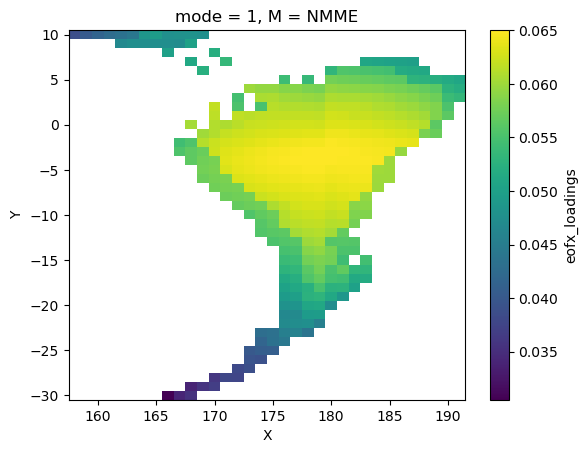

In [24]:
predict_dict = {
    'model': 'x',
    'observations': 'y'
}
loadings_test = globals()[('_'.join([predict_dict[target_focus], loadings_type, 'loadings_test']))]
loadings_test.isel(L=0, mode = 0).mean(dim = 'T').plot()

Examining x_cca_loadings_test


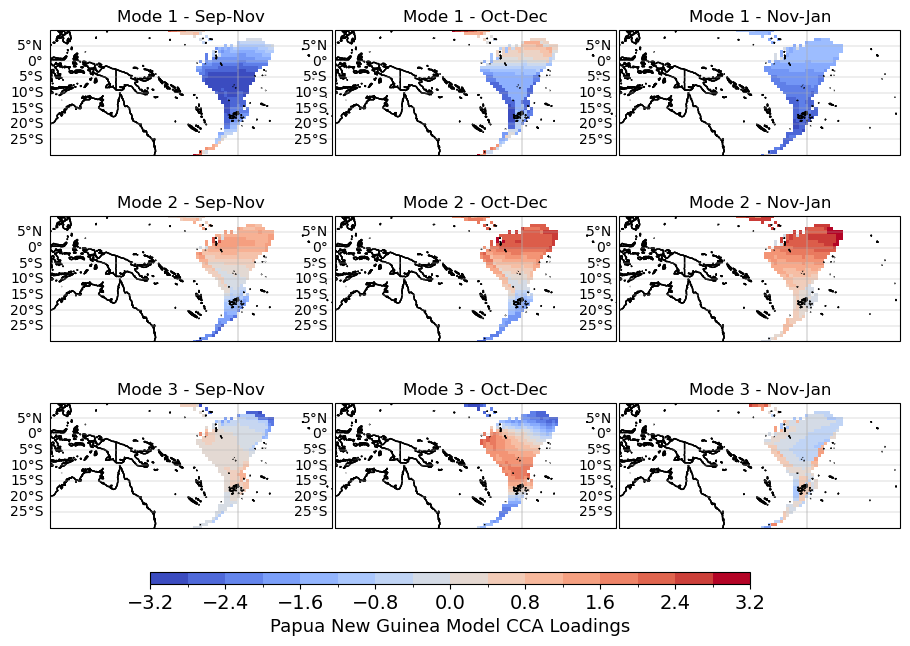

In [19]:
predict_dict = {
    'model': 'x',
    'observations': 'y'
}
loadings_test = globals()[('_'.join([predict_dict[target_focus], loadings_type, 'loadings_test']))]
print('Examining ' + ('_'.join([predict_dict[target_focus], loadings_type, 'loadings_test'])))

if target_focus == 'observations':
    spatial_extent = region_coords.copy()
elif target_focus == 'model':
    spatial_extent = predictor_train_extent.copy()
    
modes = np.unique(loadings_test.mode.values)

fig, axes = plt.subplots(nrows=len(modes), ncols=len(target_seas), figsize=(10, (len(modes)-1)*2 + 2), 
                         subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})

# Set the extent to cover the entire world
for ax in axes.flat:
    ax.set_global()
    # ax._autoscaleXon = False
    # ax._autoscaleYon = False

for j, mode in enumerate(modes):
    for i, season in enumerate(target_seas):
        ax = axes[j, i]
        # Your plotting code here using the specific mode and season
        xplot = loadings_test.mean(dim = 'T').isel(L=i, mode=j).plot(ax=ax,
                                              transform=ccrs.PlateCarree(),
                                              cmap='coolwarm', levels=21, add_colorbar=False)
        ax.coastlines()
        c = ax.coastlines()
        c = ax.gridlines(draw_labels=True, linewidth=0.3)
        c.right_labels = False
        c.top_labels = False 
        c.bottom_labels = False
        
        # Add country borders
        ax.add_feature(NaturalEarthFeature(category='cultural', name='admin_0_countries', 
                                            scale='50m', edgecolor='black', facecolor='none'))
        # Set the extent to cover the specific area
        ax.set_extent([spatial_extent['west'], spatial_extent['east'], spatial_extent['south'], spatial_extent['north']], crs=ccrs.PlateCarree())
        ax.set_title(None)
        ax.set_title('Mode ' + f'{mode} - {season}')
        
# Add a single horizontal colorbar below the panel plot
cbar_ax = fig.add_axes([0.15, 0.002, 0.6, 0.02])  # [left, bottom, width, height]
cbar = fig.colorbar(xplot, cax=cbar_ax, orientation='horizontal', shrink =1, pad = 0.3)
cbar.set_label(region_of_interest + ' ' + target_focus.capitalize() + ' ' + loadings_type.upper() + ' Loadings', fontsize=13)
cbar.ax.tick_params(labelsize=14)
# Adjust layout
plt.subplots_adjust(left=0.05, right=0.9, top=0.95, bottom=0.07, wspace=0.01, hspace=0.2)

# Show plot
plt.show()
#To save plot replace plt.show() with plt.savefig(os.path.join(figure_dir, '_'.join([initial_month_name, region_of_interest, target_focus.upper(), loadings_type.upper(), predictor_type, predictor_train_extent_name, LOADINGS_CCA'])), bbox_inches='tight', dpi=100)

## Evaluate Performance of Raw vs Bias Corrected Models

#### Pearson Correlation Coefficient

In [ ]:
start_time = time.time()
#calculate pearson correlation score for hindcasts
pearson_cca, pearson_raw = [], []
for l, lead in enumerate(np.unique(hindcast_data.L.values)):
    cca_pearson_calc = xc.Pearson(cca_hcasts_det.isel(L=l),obs_to_test.isel(L=l))
    cca_pearson_calc = cca_pearson_calc.expand_dims({'M':['NMME CCA']})

    #regrid raw data for pearson calculation on one to one grid
    raw_regrid = xc.regrid(hindcast_data.isel(L=l).precip, obs_leads.X, obs_leads.Y)
    hindcast_raw = raw_regrid * mask_missing
    
    #calc pearson correlation
    pearson_raw_calc = []
    for m, model in enumerate(np.unique(hindcast_raw.M.values)):
        pearson_raw_c = xc.Pearson(hindcast_raw.sel(M=model).expand_dims({'M':[model]}), 
                                           obs_leads.isel(L=l).precip)
        pearson_raw_c = pearson_raw_c.expand_dims({'M':[model + ' Raw']})
        pearson_raw_calc.append(pearson_raw_c)
    pearson_raw_calc = xr.concat(pearson_raw_calc, dim = 'M')
    pearson_cca.append(cca_pearson_calc)
    pearson_raw.append(pearson_raw_calc)
pearson_cca = xr.concat(pearson_cca, dim = 'L')
pearson_raw = xr.concat(pearson_raw, dim = 'L')
pearsons = xr.concat([pearson_cca, pearson_raw], dim = 'M')
print('Pearson processing time is ' + str(time.time() - start_time))

In [ ]:
models = np.unique(pearsons.M.values)
models = np.flip(models, axis = 0)

fig, axes = plt.subplots(nrows=len(models), ncols=len(target_seas), figsize=(10, (2)*2 + 2), 
                         subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})

# Set the extent to cover the entire world
for ax in axes.flat:
    ax.set_global()
    ax._autoscaleXon = False
    ax._autoscaleYon = False

for j, model in enumerate(models):
    for i, season in enumerate(target_seas):
        ax = axes[j, i]
        # Your plotting code here using the specific model and season
        xplot = pearsons.isel(L=i, M=j).plot(ax=ax,
                                              transform=ccrs.PlateCarree(),
                                              cmap='coolwarm', levels=21, vmin=-1, vmax=1, add_colorbar=False)
        ax.coastlines()
        c = ax.coastlines()
        c = ax.gridlines(draw_labels=True, linewidth=0.3)
        c.right_labels = False
        c.top_labels = False 
        # Add country borders
        ax.add_feature(NaturalEarthFeature(category='cultural', name='admin_0_countries', 
                                            scale='50m', edgecolor='black', facecolor='none'))
        # Set the extent to cover the specific area
        ax.set_extent([region_coords['west'], region_coords['east'], region_coords['south'], region_coords['north']], crs=ccrs.PlateCarree())
        ax.set_title(f'{model} - {season}')

# Add a single horizontal colorbar below the panel plot
cbar_ax = fig.add_axes([0.15, 0.002, 0.6, 0.02])  # [left, bottom, width, height]
cbar = fig.colorbar(xplot, cax=cbar_ax, orientation='horizontal', shrink =1, pad = 0.3)
cbar.set_label(region_of_interest + ' Pearson Correlation', fontsize=13)
cbar.ax.tick_params(labelsize=14)
# Adjust layout
plt.subplots_adjust(left=0.05, right=0.9, top=0.95, bottom=0.07, wspace=0.01, hspace=0.2)

# Show plot
plt.savefig(os.path.join(figure_dir, '_'.join([initial_month_name, region_of_interest, predictor_type, predictor_train_extent_name, 'pearson_CCA'])), bbox_inches='tight', dpi=100)

#### GROCS
to run this code we need a couple of functions to help transform the observational data into tercile categories
make sure to add 'onehotupdate.py' to the function folder where you pull it from in the next step. You can make the function folder the same folder as your project directory, just make sure the folder name is where this file is located

In [ ]:
#grab the necessary functions
import importlib.util

#onehotupdate.py file and where it is located
function_folder = "/cpc/int_desk/pac_isl/analysis/xcast/seasonal/onehotupdate.py"

spec = importlib.util.spec_from_file_location(
"onehotupdate", function_folder)    

onehot = importlib.util.module_from_spec(spec) 
spec.loader.exec_module(onehot)

In [ ]:
grocs_cca = []
for l, lead in enumerate(np.unique(hindcast_data.L.values)):

    hind_prob = xc.gaussian_smooth(cca_hcasts_prob.isel(L=l), kernel=3)
    obs = xc.gaussian_smooth(obs_to_test.isel(L=l), kernel=3)

    #transform obs into tercile based categories
    ohc = onehot.OneHotEncoder() 
    ohc.fit(obs)
    T = ohc.transform(obs)
    clim = xr.ones_like(T) * 0.333
    
    grocs_cca_l = xc.GROCS(hind_prob, T)
    grocs_cca_l = grocs_cca_l.expand_dims({'M':['NMME CCA']})
    grocs_cca.append(grocs_cca_l)

grocs_cca = xr.concat(grocs_cca, dim = 'L')
grocs = grocs_cca.copy()

In [ ]:
models = np.unique(grocs.M.values)
print(target_seas)
fig, axes = plt.subplots(nrows = len(models), ncols=len(target_seas), figsize=(10, (1)*2 + 2), 
                         subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})

# Set the extent to cover the entire world
for ax in axes.flat:
    ax.set_global()
    ax._autoscaleXon = False
    ax._autoscaleYon = False
for j, model in enumerate(grocs.M.values):
    for i, season in enumerate(target_seas):
        ax = axes[i]
        # Your plotting code here using the specific model and season
        xplot = grocs.isel(L=i, M=j).plot(ax=ax, transform=ccrs.PlateCarree(),
                                              cmap='coolwarm', levels=21, vmin=0, vmax=1, add_colorbar=False)
        ax.coastlines()
        c = ax.coastlines()
        c = ax.gridlines(draw_labels=True, linewidth=0.3)
        c.right_labels = False
        c.top_labels = False 
        # Add country borders
        ax.add_feature(NaturalEarthFeature(category='cultural', name='admin_0_countries', 
                                            scale='50m', edgecolor='black', facecolor='none'))
        # Set the extent to cover the specific area
        ax.set_extent([region_coords['west'], region_coords['east'], region_coords['south'], region_coords['north']], crs=ccrs.PlateCarree())
        ax.set_title(f'{model} - {season}')

# Add a single horizontal colorbar below the panel plot
cbar_ax = fig.add_axes([0.15, 0.002, 0.6, 0.02])  # [left, bottom, width, height]
cbar = fig.colorbar(xplot, cax=cbar_ax, orientation='horizontal', shrink =1, pad = 0.3)
cbar.set_label(region_of_interest + ' GROCS', fontsize=13)
cbar.ax.tick_params(labelsize=14)
# Adjust layout
plt.subplots_adjust(left=0.05, right=0.9, top=0.95, bottom=0.05, wspace=0.01, hspace=0.2)

# Show plot
plt.savefig(os.path.join(figure_dir, '_'.join([initial_month_name, region_of_interest, predictor_type, predictor_train_extent_name, 'GROCS_CCA'])), bbox_inches='tight', dpi=100)

## Plot some Probabalistic Forecasts

### Plot the Bias Corrected Forecasts using CCA

In [ ]:
for l, lead in enumerate(np.unique(cca_fcsts_prob.L)):
    im = xc.view_probabilistic(cca_fcsts_prob.isel(T=0, L=l).sel(X=slice(region_coords['west'], region_coords['east']),
                                                                   Y=slice(region_coords['south'], region_coords['north'])), cross_dateline=True,
                             title= region_of_interest + ' CCA MME Probabilistic Forecast for ' + target_seas[l],
                             savefig=os.path.join(figure_dir, '_'.join(['im' + initial_month_name, target_seas[l],region_of_interest, predictor_type, predictor_train_extent_name, 'CCA_forecast','CMORPH.png'])))